In [1]:
from dotenv import load_dotenv
import os
from langgraph.prebuilt import create_react_agent
from langchain_core.prompts import ChatPromptTemplate
from langgraph.types import Command
from langchain_core.messages import AIMessage, HumanMessage
from langgraph.graph import MessagesState,StateGraph,START, END
from typing_extensions import TypedDict
from langchain_groq import ChatGroq
from langchain_openai import ChatOpenAI
from typing import Literal
from typing import Annotated
from langchain_core.tools import tool
from langchain_community.tools.yahoo_finance_news import YahooFinanceNewsTool
from langgraph.prebuilt import create_react_agent
from langchain_fmp_data.tools import ResponseFormat
from langchain_tavily import TavilySearch

from langchain_community.tools.pubmed.tool import PubmedQueryRun
from langchain_fmp_data import FMPDataTool

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [2]:
load_dotenv()

True

In [3]:
os.environ["FMP_API_KEY"] = os.getenv("FMP_API_KEY")
os.environ["SERP_API_KEY"] = os.getenv("SERP_API_KEY")

In [4]:
# llm=ChatGroq(model="deepseek-r1-distill-llama-70b")
llm=ChatOpenAI(
    model="gpt-4o"
)

In [40]:
print(llm.invoke("Hi?"))

content='Hello! How can I assist you today?' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 9, 'prompt_tokens': 9, 'total_tokens': 18, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': None, 'id': 'chatcmpl-BtTVge72MgEsN1IbUdDeTGz6N9aM7', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None} id='run--47609bba-3179-425a-b004-0bfd76ae36c0-0' usage_metadata={'input_tokens': 9, 'output_tokens': 9, 'total_tokens': 18, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}


### Message Satate class

In [5]:
class State(MessagesState):
    next:str

## Supervisor Node

In [6]:
class SupervisorRouter(TypedDict):
    next: Literal['research_supervisor', 'reports_supervisor', '__end__']

In [7]:
supervisor_agent_prompt = f"""
You are a Supervisor Agent responsible for routing user requests to the appropriate sub-agent based on the intent and context of the conversation. Your role is to analyze the user's messages and the conversation state to determine the next step in the workflow. You can route to one of the following commands:

- **research_supervisor**: Routes to agents handling medical/pharma research or financial research. Select this if the user is asking for information, analysis, or insights related to medical/pharma topics (e.g., drug discovery, clinical trials, healthcare data) or financial topics (e.g., market analysis, stock trends, investment strategies).
- **reports_supervisor**: Routes to agents responsible for generating summaries, reports, or formatted outputs (e.g., PDF or DOCX documents) based on research or conversation results. Select summary agent before giving result. Select this if the user requests a summary, document, or formatted output, or if research has been completed and a summary needs to be generated.
- **__end__**: Terminates the workflow if the user's request has been fully addressed, no further action is needed, or the intent is unclear and cannot be routed.

### Input:
The state object, which inherits from MessagesState, contains:
- A 'next' field (str) indicating the current stage of the workflow or the next agent to route to.
- Conversation history (messages) containing user requests and agent responses.

### Instructions:
1. Analyze the 'next' field and the conversation history in the state to identify the user's intent and workflow stage.
2. If the 'next' field indicates research is needed (e.g., 'next' is empty, null, or set to 'research'), or the user's latest message requests medical/pharma or financial research, route to 'research_supervisor'.
3. If the 'next' field indicates research is complete (e.g., 'next' is set to 'research_complete' or similar), or the user requests a summary, report, or formatted output (e.g., PDF or DOCX), route to 'reports_supervisor'.
4. If research has been completed (e.g., messages contain research results and 'next' is 'research_complete'), always route to 'reports_supervisor' to generate and save a summary in PDF or DOCX format, even if not explicitly requested by the user.
5. If the 'next' field or intent is ambiguous, unclear, or the workflow is complete (e.g., 'next' is 'done' or messages indicate no further action), route to '__end__'.
6. Provide a single command as output: 'research_supervisor', 'reports_supervisor', or '__end__'.
7. Do not provide explanations or additional text beyond the command name.
"""

In [8]:
def supervisor_agent(state:State)->Command[Literal['research_supervisor', 'reports_supervisor', '__end__']]:
    """Supervisor Agent function to route user requests based on intent and context."""
    # Print the state for debugging purposes
    print(f"---------------- Supervisor Agent invoked with state: {state} ----------------")

    # Prepare the messages for the LLM, including the system prompt
    messages = [{"role": "system", "content": supervisor_agent_prompt},] + state["messages"]

    llm_with_supervisor_router = llm.with_structured_output(SupervisorRouter)

    response=llm_with_supervisor_router.invoke(messages)

    print(f"response: {response}")

    goto = response["next"]
    # print(f"response: {response} \ngoto: {goto}")

    # print(f"goto: {goto}")
    
    if goto == '__end__':
        goto=END

    print(f"command : {Command(goto=goto, update={'next': goto})}")
    return Command(goto=goto, update={"next": goto})

## 1. Reaserach Team

#### 1.1 Reaserach Router

In [9]:
class ResearchRouter(TypedDict):
    next: Literal['medical_agent', 'finance_agent', 'FINISH']

In [10]:
research_team_members = ["medical_agent", "finance_agent"]
report_team_members = ["summary_agent", "report_agent"]

In [11]:
# research_team_supervisor_prompt = f""" 
# You are a Research Team Supervisor Agent responsible for routing research tasks to the appropriate agent based on their domain. Your task is to analyze the research request in the provided state and determine which agent should handle it. The possible agents are:

# medical_agent: For research tasks related to medical, pharmaceutical, healthcare, or biological topics.
# finance_agent: For research tasks related to finance, economics, banking, investments, or financial markets.
# When finished, respond with FINISH.

# Input: The state object contains the research request, which includes a description of the task or query to be researched.
# Instructions:

# Analyze the research request in the state to identify its domain.
# If the request involves medical, pharmaceutical, healthcare, or biological topics, Route to the command "medical_agent".
# If the request involves finance, economics, banking, investments, or financial markets, Route to the command "finance_agent".
# For any other topic or if the request is ambiguous and requires higher-level decision-making, Route to the command "supervisor".
# Route only the command name as a string: "medical_agent", "finance_agent", or "supervisor".
# Do not provide explanations or additional text beyond the command name.

# """

research_team_supervisor_prompt = f""""
You are a supervisor, tasked with managing a conversation between the following workers: {research_team_members}. 
Given the following user request, respond with the worker to act next. 
Each worker will perform a task and respond with their results and status. 
When finished, respond with FINISH.
"""


#### 1.2 Reaserach team supervisor:

In [12]:
def reresearch_team_supervisor_agent(state:State)->Command[Literal['medical_agent', 'finance_agent', 'supervisor']]:
    # Print the state for debugging purposes
    print(f"---------------- Reasreach team Agent invoked with state: {state} ----------------")

    # Prepare the messages for the LLM, including the system prompt
    messages = [{"role": "system", "content": research_team_supervisor_prompt},] + state["messages"]

    llm_with_research_router = llm.with_structured_output(ResearchRouter)

    response=llm_with_research_router.invoke(messages)

    goto = response["next"]
    print(f"response: {response} \ngoto: {goto}")

    if goto == "FINISH":
        goto="supervisor"

    print(f"command : {Command(goto=goto, update={'next': goto})}")
    return Command(goto=goto, update={"next": goto})

##### 1.2.1 Medical Pharma Agent:

In [13]:
medical_tools = [PubmedQueryRun(), TavilySearch()]
# medical_research_agent_prompt = f"""
# You are a Medical Research Agent responsible for conducting research on medical, pharmaceutical, healthcare, or biological topics based on the user's request. Your task is to analyze the request, provide relevant information, insights, or data, and route the workflow appropriately.
# available tools: {medical_tools}
# ### Input:
# The state object, which inherits from MessagesState, contains:
# - A 'next' field (str) indicating the current stage of the workflow or the next agent to route to.
# - Conversation history (messages) containing user requests and prior responses.

# ### Instructions:
# 1. Analyze the user's latest request and conversation history in the state to identify the medical research topic (e.g., disease information, treatment options, pharmaceutical data, healthcare trends, or biological mechanisms).
# 2. If the 'next' field is empty, null, or indicates a new research task (e.g., 'research'), conduct the medical research using available data in the state or your knowledge base. Store the results in the state and set 'next' to 'research_complete'.
# 3. If up-to-date information or news is required and not available in your knowledge base, route to the command 'tavily_search' to fetch the latest data using the TavilySearch tool.
# 4. If research is complete (e.g., 'next' is 'research_complete' or the state contains sufficient research results), route to the command 'reports_supervisor' to generate a summary in PDF or DOCX format.
# 5. If the request is ambiguous, incomplete, or requires higher-level expertise (e.g., proprietary medical data or clinical trial access), route to the command 'research_supervisor' with appropriate feedback in the state.
# 6. Provide a single command as output: 'tavily_search', 'reports_supervisor', or 'research_supervisor'.
# 7. Do not provide explanations or additional text beyond the command name.
# """
medical_research_agent_prompt = f"""
You are a Medical Research Agent responsible for conducting research on medical, pharmaceutical, healthcare, or biological topics based on the user's request. Your task is to analyze the request, provide relevant information, insights, or data, and route the workflow appropriately.
available tools: {medical_tools}
"""


In [14]:
def medical_agent(state:State)->Command[Literal['research_supervisor']]:
    print(f"---------------- Medical Agent invoked with state: {state} ----------------")
    medical_agent=create_react_agent(model=llm, tools=medical_tools, prompt=medical_research_agent_prompt)
    result=medical_agent.invoke(state)

    print(f'''command : {Command(
        goto="research_supervisor",
        update={"messages": [
            HumanMessage(content=result["messages"][-1].content, name="medical_agent")
        ]}
    )}''')
    return Command(
        goto="research_supervisor",
        update={"messages": [
            HumanMessage(content=result["messages"][-1].content, name="medical_agent")
        ]}
    )



##### 1.2.2 Financial Agent:

In [32]:
finance_tools = [YahooFinanceNewsTool(), TavilySearch()]
# finance_tools = [TavilySearch()]

# financial_research_agent_prompt = f"""
# You are a Financial Research Agent responsible for conducting research on financial topics based on the user's request. Your task is to analyze the request, provide relevant information, insights, or data related to finance, economics, banking, investments, or financial markets, and route the workflow appropriately.
# available tools: {finance_tools}
# ### Input:
# The state object, which inherits from MessagesState, contains:
# - A 'next' field (str) indicating the current stage of the workflow or the next agent to route to.
# - Conversation history (messages) containing user requests and prior responses.

# ### Instructions:
# 1. Analyze the user's latest request and conversation history in the state to identify the financial research topic (e.g., market analysis, stock trends, investment strategies, economic data).
# 2. If the 'next' field is empty, null, or indicates a new research task (e.g., 'research'), conduct the financial research using available data in the state or your knowledge base. Store the results in the state and set 'next' to 'research_complete'.
# 3. If up-to-date information or news is required and not available in your knowledge base, route to the command 'tavily_search' to fetch the latest news or data.
# 4. If research is complete (e.g., 'next' is 'research_complete' or the state contains sufficient research results), route to the command 'reports_supervisor' to generate a summary in PDF or DOCX format.
# 5. If the request is ambiguous, incomplete, or requires higher-level oversight, route to the command 'research_supervisor' with appropriate feedback in the state.
# 6. Provide a single command as output: 'tavily_search', 'reports_supervisor', or 'research_supervisor'.
# 7. Do not provide explanations or additional text beyond the command name.
# """

financial_research_agent_prompt = f"""
You are a Financial Research Agent responsible for conducting research on financial topics based on the user's request. Your task is to analyze the request, provide relevant information, insights, or data related to finance, economics, banking, investments, or financial markets, and route the workflow appropriately.
available tools: {finance_tools}.
"""

In [16]:
def finance_agent(state:State)->Command[Literal['research_supervisor']]:
    print(f"---------------- Finance Agent invoked with state: {state} ----------------")
    finance_agent = create_react_agent(model=llm, tools=finance_tools, prompt=financial_research_agent_prompt)
    result = finance_agent.invoke(state)
    print(f"finance result: {result}")
    return Command(
        goto="research_supervisor",
        update={"messages": [
            HumanMessage(content=result["messages"][-1].content, name="finance_agent")
        ]}
    )

In [17]:
# finance_agent({
#     "messages": ["Give me the latest news on stock market trends and investment strategies."]})

## 2. Reports Team

#### 2.1 Reports Router

In [18]:
class ReportsRouter(TypedDict):
    next: Literal['summary_agent', 'document_agent', 'FINISH']

In [19]:
report_team_supervisor_prompt = f"""
You are a Reports Team Supervisor Agent responsible for managing the workflow of generating and saving research summaries. Your task is to route the workflow based on the current state of the research process. The possible agents are:

summary_agent: For generating a summary of all prior research data contained in the state.
document_agent: For saving the generated summary in PDF or DOCX format.
When finished, respond with FINISH.

Input: The state object contains the research data, including prior research, the current status of the summary, and any instructions for saving the output.
Instructions:

Analyze the state to determine the current stage of the workflow.
If no summary has been generated, route to the command "summary_agent" to create a summary of all prior research.
If a summary has been generated but not saved, route to the command "document_agent" to save the summary in PDF or DOCX format, as specified in the state or context.
If the summary has been generated and saved, route to the command "supervisor" to return control to the higher-level supervisor with the updated state, including the saved document's metadata (e.g., file path or format).
If the state is ambiguous or contains errors (e.g., missing research data or invalid format), route to the command "supervisor" with appropriate feedback in the state.
Route only the command name as a string: "summary_agent", "document_agent", or "supervisor".
Do not provide explanations or additional text beyond the command name.
"""

#### 2.2 Reports team supervisor:

In [36]:
def reports_team_supervisor_agent(state:State)->Command[Literal['summary_agent', 'document_agent','supervisor']]:
    print(f"---------------- Report team Agent invoked with state: {state} ----------------")

    # Prepare the messages for the LLM, including the system prompt
    messages = [{"role": "system", "content": report_team_supervisor_prompt},] + state["messages"]

    llm_with_research_router = llm.with_structured_output(ReportsRouter)

    response=llm_with_research_router.invoke(messages)

    goto = response["next"]
    print(f"response: {response} \ngoto: {goto}")

    if goto == "FINISH":
        goto="supervisor"

    print(f"command : {Command(goto=goto, update={'next': goto})}")
    return Command(goto=goto, update={"next": goto})

##### 2.2.1 Summry of result Agent:

In [21]:
medical_sumary_agent_prompt = f"""
You are a Summary Agent responsible for generating a concise summary based on research data provided from a research agent.

### Instructions:
1. Analyze the research data and the original question to identify key findings.
2. Summarize the findings in a clear, concise, and structured format (e.g., bullet points or short paragraphs).
3. If the research data is insufficient or unclear, use the TavilySearch tool to fetch additional relevant information.
4. Ensure the summary is accurate, relevant to the question's domain, and avoids unnecessary details.
5. If the request requires advanced expertise or proprietary data, include the command 'research_supervisor' in the response.
"""

In [22]:
@tool
def summary_tool(state:State):
    """
    Summary Agent function to generate a summary based on the provided state.

    Args:
        state: The input state to summarize (can be any type, converted to string).

    Returns:
        str: The generated summary.

    Raises:
        ValueError: If the state is None or empty.
        LangChainException: If the LLM invocation fails.
    """
    print(f"---------------- summary_tool invoked with state: {state} ----------------")
    prompt = ChatPromptTemplate.from_template("""
        You are a Summary Agent.

        Extract insights from this state:

        {state}

        Output:
        Summary:""")
    
    chain = prompt | llm
    result = chain.invoke({"state": state})
    print(f"Summary result: {result}")
    return result
    
    

In [23]:
summary_agent_prompt=f"""
You are a Summary Agent responsible for generating a concise and accurate summary based on the provided state, which includes conversation history and research results. 
Your task is to analyze the state, extract key insights, and produce a structured summary for inclusion in a report (e.g., PDF or DOCX).
"""

def summary_agent(state:State)->Command[Literal['reports_supervisor']]:
    summary_agent = create_react_agent(model=llm, tools=[summary_tool],prompt=summary_agent_prompt)
    result = summary_agent.invoke(state)

    return Command(
        goto="reports_supervisor",
        update={"messages": [
            HumanMessage(content=result["messages"][-1].content, name="summary_agent")
        ]}
    )

##### 2.2.2 Document Agent:

In [41]:
# import os
# import re
# from datetime import datetime

# def pdf_report_tool(summary: str = None, question_name: str = "default_report") -> str:
#     """
#     Generates a LaTeX document for a PDF report containing the provided summary and saves it to the 'docs_result/' folder.

#     Args:
#         summary (str, optional): The summary content to include in the LaTeX document. If None, returns an error message.
#         question_name (str, optional): The name of the question to use as the filename (default: 'default_report').

#     Returns:
#         str: Confirmation message with the file path or an error message.

#     Raises:
#         OSError: If there are issues creating the directory or saving the file.
#     """
#     if not summary:
#         return "Error: No summary provided for PDF generation."

#     # Ensure the docs_result directory exists
#     output_dir = "docs_result"
#     try:
#         os.makedirs(output_dir, exist_ok=True)
#     except OSError as e:
#         return f"Error: Failed to create directory '{output_dir}': {str(e)}"

#     # Sanitize question_name to create a valid filename
#     sanitized_name = re.sub(r'[^\w\s-]', '', question_name).strip().replace(' ', '_')
#     if not sanitized_name:
#         sanitized_name = "default_report"
#     file_path = os.path.join(output_dir, f"{sanitized_name}.tex")

#     # Escape special LaTeX characters in the summary
#     latex_escape_chars = {
#         '&': r'\&', '%': r'\%', '$': r'\$', '#': r'\#', '_': r'\_',
#         '{': r'\{', '}': r'\}', '~': r'\textasciitilde{}', '^': r'\textasciicircum{}',
#         '\\': r'\textbackslash{}'
#     }
#     escaped_summary = summary
#     for char, escape in latex_escape_chars.items():
#         escaped_summary = escaped_summary.replace(char, escape)

#     # Parse summary for lists (similar to docx_report_tool)
#     lines = escaped_summary.split("\n")
#     latex_summary = []
#     in_itemize = False
#     in_enumerate = False
#     for line in lines:
#         line = line.strip()
#         if not line:
#             if in_itemize:
#                 latex_summary.append(r"\end{itemize}")
#                 in_itemize = False
#             if in_enumerate:
#                 latex_summary.append(r"\end{enumerate}")
#                 in_enumerate = False
#             continue
#         if re.match(r"^[-*]\s+", line):
#             if not in_itemize:
#                 latex_summary.append(r"\begin{itemize}")
#                 in_itemize = True
#             if in_enumerate:
#                 latex_summary.append(r"\end{enumerate}")
#                 in_enumerate = False
#             latex_summary.append("\\item " + line[2:].strip())
#         elif re.match(r"^\d+\.\s+", line):
#             if not in_enumerate:
#                 latex_summary.append(r"\begin{enumerate}")
#                 in_enumerate = True
#             if in_itemize:
#                 latex_summary.append(r"\end{itemize}")
#                 in_itemize = False
#             latex_summary.append("\\item " + re.sub(r'^\d+\.\s+', '', line).strip())
#         else:
#             if in_itemize:
#                 latex_summary.append(r"\end{itemize}")
#                 in_itemize = False
#             if in_enumerate:
#                 latex_summary.append(r"\end{enumerate}")
#                 in_enumerate = False
#             latex_summary.append(line)
#     if in_itemize:
#         latex_summary.append(r"\end{itemize}")
#     if in_enumerate:
#         latex_summary.append(r"\end{enumerate}")

#     # Join the processed summary lines
#     formatted_summary = "\n".join(latex_summary)

#     # Comprehensive LaTeX preamble
#     latex_content = rf"""
# \documentclass[a4paper,12pt]{{article}}
# \usepackage[utf8]{{inputenc}}
# \usepackage[T1]{{fontenc}}
# \usepackage{{geometry}}
# \usepackage{{parskip}}
# \usepackage{{enumitem}}
# \usepackage{{noto}}
# \geometry{{margin=1in}}
# \title{{Research Summary Report}}
# \author{{}}
# \date{{\today}}

# \begin{{document}}
# \maketitle
# \section*{{Summary}}
# {formatted_summary}
# \end{{document}}
# """

#     # Save the LaTeX content to the file
#     try:
#         with open(file_path, 'w', encoding='utf-8') as f:
#             f.write(latex_content)
#         return f"Success: LaTeX file saved to '{file_path}'. Compile with latexmk -pdf to generate PDF."
#     except OSError as e:
#         return f"Error: Failed to save LaTeX file to '{file_path}': {str(e)}"

In [25]:
from docx import Document
from datetime import datetime
import re
import os

@tool
def docx_report_tool(summary: str = None, question_name: str = "default_report") -> str:
    """
    Generates a DOCX document containing the provided summary and saves it to the 'docs_result/' folder.

    Args:
        summary (str, optional): The summary content to include in the DOCX. If None, returns an error message.
        question_name (str, optional): The name of the question to use as the filename (default: 'default_report').

    Returns:
        str: Confirmation message with the file path or an error message.

    Raises:
        OSError: If there are issues creating the directory or saving the file.
    """
    if not summary:
        return "Error: No summary provided for DOCX generation."

    # Ensure the docs_result directory exists
    output_dir = "docs_result"
    try:
        os.makedirs(output_dir, exist_ok=True)
    except OSError as e:
        return f"Error: Failed to create directory '{output_dir}': {str(e)}"

    # Sanitize question_name to create a valid filename
    sanitized_name = re.sub(r'[^\w\s-]', '', question_name).strip().replace(' ', '_')
    if not sanitized_name:
        sanitized_name = "default_report"
    file_path = os.path.join(output_dir, f"{sanitized_name}.docx")

    # Create a new Document
    doc = Document()
    doc.add_heading("Research Summary Report", 0)
    doc.add_paragraph(f"Generated on: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

    # Parse summary for formatting (e.g., detect bullet points or numbered lists)
    lines = summary.split("\n")
    current_list = None
    for line in lines:
        line = line.strip()
        if not line:
            continue
        # Detect bullet points (e.g., "- Item" or "* Item")
        if re.match(r"^[-*]\s+", line):
            if current_list is None:
                current_list = doc.add_paragraph(style="ListBullet")
            else:
                current_list = doc.add_paragraph(style="ListBullet")
            current_list.add_run(line[2:].strip())
        # Detect numbered lists (e.g., "1. Item")
        elif re.match(r"^\d+\.\s+", line):
            if current_list is None or current_list.style.name != "ListNumber":
                current_list = doc.add_paragraph(style="ListNumber")
            else:
                current_list = doc.add_paragraph(style="ListNumber")
            current_list.add_run(re.sub(r"^\d+\.\s+", "", line).strip())
        else:
            current_list = None
            doc.add_paragraph(line)

    # Save the document to the specified file path
    try:
        doc.save(file_path)
        return f"Success: DOCX file saved to '{file_path}'"
    except OSError as e:
        return f"Error: Failed to save DOCX file to '{file_path}': {str(e)}"

In [42]:

report_agent_tools = [docx_report_tool]

report_agent_prompt = f"""You are a Document Agent responsible for generating and saving research summaries in PDF or DOCX format. 
Your task is to analyze the provided state, which includes the summary content and the desired output format, and produce the document accordingly.
If user has not specified the format, choose DOCX as the default format.
available tools: {report_agent_tools}
"""

In [43]:
def document_agent(state:State)->Command[Literal['reports_supervisor']]:
    document_agent = create_react_agent(model=llm, tools=report_agent_tools, prompt=report_agent_prompt)
    result = document_agent.invoke(state)


    return Command(
        goto="reports_supervisor",
        update={"messages": [
            HumanMessage(content=result["messages"][-1].content, name="document_agent")
        ]}
    )

### Graph workflow

In [44]:
graph=StateGraph(State)
graph.add_node("supervisor", supervisor_agent)

graph.add_node("research_supervisor", reresearch_team_supervisor_agent)
graph.add_node("medical_agent", medical_agent)
graph.add_node("finance_agent", finance_agent)

graph.add_node("reports_supervisor",reports_team_supervisor_agent)
graph.add_node("summary_agent", summary_agent)
graph.add_node("document_agent", document_agent)    

graph.add_edge(START,"supervisor")

# graph.add_edge("supervisor", "research_supervisor")
# graph.add_edge("research_supervisor", "supervisor")
# graph.add_edge("research_supervisor", "medical_agent")
# graph.add_edge("research_supervisor", "finance_agent")
# graph.add_edge("medical_agent", "research_supervisor")
# graph.add_edge("finance_agent", "research_supervisor")

# graph.add_edge("supervisor", "reports_supervisor")
# graph.add_edge("reports_supervisor", "supervisor")
# graph.add_edge("reports_supervisor", "summary_agent")
# graph.add_edge("reports_supervisor", "document_agent")
# graph.add_edge("summary_agent", "reports_supervisor")
# graph.add_edge("document_agent", "reports_supervisor")
app=graph.compile()


In [29]:

from IPython.display import display,Image

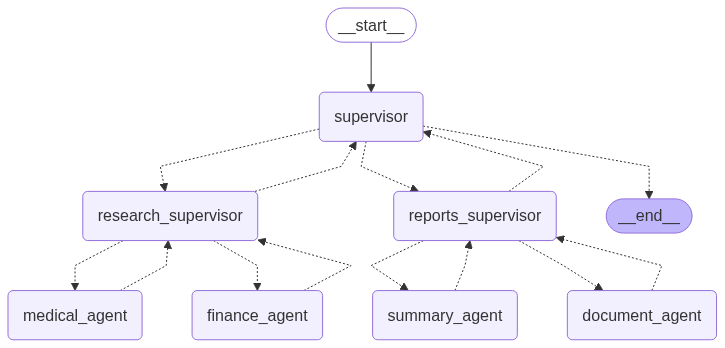

In [ ]:
display(Image(app.get_graph().draw_mermaid_png()))

In [31]:
for s in app.stream({"messages":[("user","I need to research the latest trends in AI and its applications in healthcare.")]}, subgraphs=True):
    print(s)

---------------- Supervisor Agent invoked with state: {'messages': [HumanMessage(content='I need to research the latest trends in AI and its applications in healthcare.', additional_kwargs={}, response_metadata={}, id='9ce405d9-d956-49ca-95b9-249fc5a1daaa')]} ----------------
response: {'next': 'research_supervisor'}
command : Command(update={'next': 'research_supervisor'}, goto='research_supervisor')
((), {'supervisor': {'next': 'research_supervisor'}})
---------------- Reasreach team Agent invoked with state: {'messages': [HumanMessage(content='I need to research the latest trends in AI and its applications in healthcare.', additional_kwargs={}, response_metadata={}, id='9ce405d9-d956-49ca-95b9-249fc5a1daaa')], 'next': 'research_supervisor'} ----------------
response: {'next': 'medical_agent'} 
goto: medical_agent
command : Command(update={'next': 'medical_agent'}, goto='medical_agent')
((), {'research_supervisor': {'next': 'medical_agent'}})
---------------- Medical Agent invoked wi

e:\practice\Agentic_AI_2.0\Assignements\agentic_ai\lib\site-packages\docx\styles\styles.py:125: UserWarning: style lookup by style_id is deprecated. Use style name as key instead.
  return self._get_style_id_from_style(self[style_name], style_type)


(('document_agent:99caaa8d-6bfe-e140-7c17-c0ce7e986e6c',), {'agent': {'messages': [AIMessage(content="The summary of the latest trends in AI and its applications in healthcare has been saved as a DOCX document. You can find it in the file path: 'docs_result/AI_and_Healthcare_Trends.docx'.", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 45, 'prompt_tokens': 1639, 'total_tokens': 1684, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 1536}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': None, 'id': 'chatcmpl-BtTLRzhobivfM8UJLHeejgs8h6o8p', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--f3ac4964-787e-4723-ba4c-bc368df22d61-0', usage_metadata={'input_tokens': 1639, 'output_tokens': 45, 'total_tokens': 1684, 'input_token_details': {'audio': 0, 'cache_r

In [40]:
for s in app.stream({"messages":[("user","What is stock price of Apple today. What is the latest news about apple company")]}, subgraphs=True):
    print(s)

---------------- Supervisor Agent invoked with state: {'messages': [HumanMessage(content='What is stock price of Apple today. What is the latest news about apple company', additional_kwargs={}, response_metadata={}, id='d381bc85-f6aa-4cc2-9d70-925be8a5de71')]} ----------------
response: {'next': 'research_supervisor'}
command : Command(update={'next': 'research_supervisor'}, goto='research_supervisor')
((), {'supervisor': {'next': 'research_supervisor'}})
---------------- Reasreach team Agent invoked with state: {'messages': [HumanMessage(content='What is stock price of Apple today. What is the latest news about apple company', additional_kwargs={}, response_metadata={}, id='d381bc85-f6aa-4cc2-9d70-925be8a5de71')], 'next': 'research_supervisor'} ----------------
response: {'next': 'finance_agent'} 
goto: finance_agent
command : Command(update={'next': 'finance_agent'}, goto='finance_agent')
((), {'research_supervisor': {'next': 'finance_agent'}})
---------------- Finance Agent invoked 